# X5

In [76]:
import random

import numpy as np
import pandas as pd

import torch

torch.cuda.empty_cache()

def seed_all(seed: int) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)

In [77]:
SEED = 42
# seed_all(SEED)

In [78]:
from pathlib import Path

DATA_PATH = Path('../../../data/')
DATA_PATH.mkdir(parents=True, exist_ok=True)

DATA_PATH_DOWNLOAD = DATA_PATH / Path('download/')
DATA_PATH_DOWNLOAD.mkdir(parents=True, exist_ok=True)

DATA_PATH_DATASET = DATA_PATH / Path('datasets/')
DATA_PATH_DATASET.mkdir(parents=True, exist_ok=True)

DATA_SYNTHETICS = DATA_PATH / Path('synthetics/')
DATA_PATH_DATASET.mkdir(parents=True, exist_ok=True)

DATA_CACHE = DATA_PATH / Path('cache_dir/')
DATA_CACHE.mkdir(parents=True, exist_ok=True)

DATA_PATH_SAVE_MODELS = DATA_PATH / Path('models/')
DATA_PATH_SAVE_MODELS.mkdir(parents=True, exist_ok=True)

DATA_IMGS = DATA_PATH /  Path('imgs/')
DATA_IMGS.mkdir(parents=True, exist_ok=True)

import pandas as pd

pd.set_option('display.max_colwidth', 500) 

In [79]:
import sys
import os

project_path = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(project_path)

In [80]:
BASE_MODEL_NAME = 'cointegrated/rubert-tiny2'
# BASE_MODEL_NAME = 'MoritzLaurer/mDeBERTa-v3-base-mnli-xnli'
# BASE_MODEL_NAME = 'DeepPavlov/rubert-base-cased'
MODEL_NAME_SAVE = "ner_x5"
MODEL_CHECKPOINT_PATH = "ner_x5_checkpoint"

In [81]:
from datetime import datetime

current_date = datetime.now().strftime("%d-%m-%Y")
DATA_LOG = DATA_PATH / Path(f'../logs/{MODEL_NAME_SAVE}_{current_date}')
DATA_LOG.mkdir(parents=True, exist_ok=True)

In [ ]:
MAX_LENGTH = 16
BATCH_SIZE = 128

# Данные

In [83]:
df_x5 = pd.read_csv(DATA_PATH_DATASET / "train.csv", sep=";")

In [84]:
df_x5.sample(5)

,sample,annotation
4180,бургер соус,"[(0, 6, 'B-TYPE'), (7, 11, 'I-TYPE')]"
18737,ромовая баба,"[(0, 7, 'B-TYPE'), (8, 12, 'I-TYPE')]"
1762,paterra тряпк,"[(0, 7, 'B-BRAND'), (8, 13, 'B-TYPE')]"
12038,макаронеы,"[(0, 9, 'B-TYPE')]"
2893,аэрозо,"[(0, 6, 'B-TYPE')]"


In [85]:
def normalize_annotations(ann_list):
    if isinstance(ann_list, str):
        ann_list = eval(ann_list)
    new_list = []
    for start, end, label in ann_list:
        if label == "0":
            label = "O"
        new_list.append((start, end, label))
    return new_list

df_x5["annotation"] = df_x5["annotation"].apply(normalize_annotations)

In [86]:
all_labels = set()

for ann_list in df_x5["annotation"]:
    if isinstance(ann_list, str):
        ann_list = eval(ann_list)
    for _, _, label in ann_list:
        all_labels.add(label)

unique_labels = sorted(all_labels)
unique_labels

['B-BRAND',
 'B-PERCENT',
 'B-TYPE',
 'B-VOLUME',
 'I-BRAND',
 'I-PERCENT',
 'I-TYPE',
 'I-VOLUME',
 'O']

In [87]:
import ast

def fix_annotations(ann):
    if isinstance(ann, str):
        ann = ast.literal_eval(ann)

    new_ann = []
    prev_label = None

    for start, end, label in ann:
        if label == "O":
            if prev_label is None:
                new_label = "B-TYPE"
            elif prev_label.startswith(("B-", "I-")):
                ent_type = prev_label.split("-", 1)[-1]
                new_label = f"I-{ent_type}"
            else:
                new_label = "B-TYPE"
        else:
            new_label = label

        new_ann.append((start, end, new_label))
        prev_label = new_label

    return new_ann


In [88]:


df_x5["annotation"] = df_x5["annotation"].apply(fix_annotations)


In [89]:
df_x5.sample(5)

,sample,annotation
7106,журнаыл,"[(0, 7, B-TYPE)]"
5618,говядина охлажденная,"[(0, 8, B-TYPE), (9, 20, I-TYPE)]"
8563,картофешь,"[(0, 9, B-TYPE)]"
19828,селедка под хубой,"[(0, 7, B-TYPE), (8, 11, I-TYPE), (12, 17, I-TYPE)]"
2126,sweet box,"[(0, 5, B-TYPE), (6, 9, I-TYPE)]"


In [90]:
df_submission = pd.read_csv(DATA_PATH_DATASET / "submission.csv", sep=";")
df_submission["annotation"] = df_submission["annotation"].apply(normalize_annotations)

In [91]:
import pandas as pd
from pathlib import Path
import ast

def load_synthetic_file(file_path: str | Path) -> pd.DataFrame:
    file_path = Path(file_path)
    data = []

    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            try:
                text, ann_str = line.split(";", 1)
                text = text.strip()
                annotation = ast.literal_eval(ann_str.strip())
                data.append({"sample": text, "annotation": annotation})
            except Exception as e:
                print(f"Ошибка при обработке строки в {file_path}: {line}\n{e}")

    return pd.DataFrame(data)


In [92]:
def load_synthetic_dataset(data_dir: str | Path) -> pd.DataFrame:
    data_dir = Path(data_dir)
    all_dfs = []

    for file_path in data_dir.glob("*.txt"):
        df_file = load_synthetic_file(file_path)
        all_dfs.append(df_file)

    if all_dfs:
        return pd.concat(all_dfs).reset_index(drop=True)
    else:
        return pd.DataFrame(columns=["sample", "annotation"])


In [93]:
df_synthetic = load_synthetic_dataset(DATA_SYNTHETICS)

In [94]:
df_x5["df_label"] = "x5"
df_synthetic["df_label"] = "synthetic"

dfs = []
dfs.append(df_x5)
# dfs.append(df_synthetic)

In [95]:
print("Размеры датафреймов. df_x5:", df_x5.shape, ", df_synthetic:", df_synthetic.shape)

Размеры датафреймов. df_x5: (27251, 3) , df_synthetic: (4004, 3)


In [96]:
df_train = pd.concat(dfs, ignore_index=True)
# df_train = df_train.drop_duplicates(subset=["sample"]).reset_index(drop=True)

In [97]:
df_synthetic.sample(5)

,sample,annotation,df_label
3810,свинина говядина,"[(0, 7, B-TYPE), (8, 16, B-TYPE)]",synthetic
1888,корзинка плетёная милка,"[(0, 8, B-TYPE), (9, 17, I-TYPE), (18, 23, B-BRAND)]",synthetic
2043,фарш куричий сочн,"[(0, 4, B-TYPE), (5, 13, I-TYPE), (14, 18, I-TYPE)]",synthetic
988,сыр моцарелла галбани шарики 45% 125 г,"[(0, 3, B-TYPE), (4, 13, I-TYPE), (14, 21, B-BRAND), (35, 39, B-PERCENT), (40, 45, B-VOLUME)]",synthetic
805,пиво три медведя 0.45 л,"[(0, 4, B-TYPE), (5, 16, B-BRAND), (17, 22, B-VOLUME)]",synthetic


# Словари

In [98]:
unique_labels = {label for anns in df_train["annotation"] for _, _, label in anns if label != "O"}

b_labels = sorted([lbl for lbl in unique_labels if lbl.startswith("B-")])
i_labels = {lbl[2:]: lbl for lbl in unique_labels if lbl.startswith("I-")}

all_labels = ["O"]
for b in b_labels:
    all_labels.append(b)
    base = b[2:]
    if base in i_labels:
        all_labels.append(i_labels[base])

label2idx = {label: idx for idx, label in enumerate(all_labels)}
idx2label = {idx: label for label, idx in label2idx.items()}

print("label2idx:", label2idx)
print("idx2label:", idx2label)


label2idx: {'O': 0, 'B-BRAND': 1, 'I-BRAND': 2, 'B-PERCENT': 3, 'I-PERCENT': 4, 'B-TYPE': 5, 'I-TYPE': 6, 'B-VOLUME': 7, 'I-VOLUME': 8}
idx2label: {0: 'O', 1: 'B-BRAND', 2: 'I-BRAND', 3: 'B-PERCENT', 4: 'I-PERCENT', 5: 'B-TYPE', 6: 'I-TYPE', 7: 'B-VOLUME', 8: 'I-VOLUME'}


In [99]:
import json

label2idx_path = DATA_PATH_SAVE_MODELS / "label2idx.json"
idx2label_path = DATA_PATH_SAVE_MODELS / "idx2label.json"

with open(label2idx_path, "w", encoding="utf-8") as f:
    json.dump(label2idx, f, ensure_ascii=False, indent=4)

with open(idx2label_path, "w", encoding="utf-8") as f:
    json.dump(idx2label, f, ensure_ascii=False, indent=4)

print(f"Словарь label2idx сохранён в {label2idx_path}")
print(f"Словарь idx2label сохранён в {idx2label_path}")

Словарь label2idx сохранён в ..\..\..\data\models\label2idx.json
Словарь idx2label сохранён в ..\..\..\data\models\idx2label.json


# Датасет

In [100]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_data: pd.DataFrame
val_data: pd.DataFrame
train_data, test_data = train_test_split(
    df_train,
    test_size=0.1,
    shuffle=True,
    random_state=42,
)

train_data, val_data = train_test_split(
    train_data,
    test_size=0.05,
    shuffle=True,
    random_state=42,
)


In [101]:
train_data.sample(10)

,sample,annotation,df_label
11884,мажитеоь,"[(0, 8, B-TYPE)]",x5
6990,желетин,"[(0, 7, B-TYPE)]",x5
12075,макароны рожки,"[(0, 8, B-TYPE), (9, 14, I-TYPE)]",x5
4020,булочки для гаи,"[(0, 7, B-TYPE), (8, 11, I-TYPE), (12, 15, I-TYPE)]",x5
2332,yelly,"[(0, 5, B-BRAND)]",x5
1625,nestle желе,"[(0, 6, B-BRAND), (7, 11, B-TYPE)]",x5
11348,лампы прочие,"[(0, 5, B-TYPE), (6, 12, I-TYPE)]",x5
272,biomax та,"[(0, 6, B-BRAND), (7, 9, B-TYPE)]",x5
15610,панировлчная,"[(0, 12, B-TYPE)]",x5
20088,сигареты bs,"[(0, 8, B-TYPE), (9, 11, B-BRAND)]",x5


In [102]:
df_submission.head()

,sample,annotation
0,форма для выпечки,"[(0, 5, B-TYPE), (6, 9, I-TYPE), (10, 17, I-TYPE)]"
1,фарш свиной,"[(0, 4, B-TYPE), (5, 11, I-TYPE)]"
2,сок ананасовый без сахара,"[(0, 3, B-TYPE), (4, 14, I-TYPE), (15, 18, I-TYPE), (19, 25, I-TYPE)]"
3,еринги,"[(0, 6, B-TYPE)]"
4,молооко,"[(0, 7, B-TYPE)]"


In [103]:
from ml.dataset import NerDataSet

dtype_input = torch.long
dtype_labels = torch.long

train_dataset = NerDataSet(
    df=train_data, 
    max_length=MAX_LENGTH, 
    tokenizer_path=BASE_MODEL_NAME,
    cache_dir=DATA_CACHE,
    label2idx=label2idx,
    text_label='sample',
    target_label='annotation',
    dtype_input_ids=dtype_input,
    dtype_token_type_ids=dtype_input,
    dtype_attention_mask=dtype_input,
    dtype_labels=dtype_labels,
    debug=True    
)

val_dataset = NerDataSet(
    df=val_data,
    max_length=MAX_LENGTH, 
    tokenizer_path=BASE_MODEL_NAME,
    cache_dir=DATA_CACHE,
    label2idx=label2idx,
    text_label='sample',
    target_label='annotation',
    dtype_input_ids=dtype_input,
    dtype_token_type_ids=dtype_input,
    dtype_attention_mask=dtype_input,
    dtype_labels=dtype_labels,
    debug=True
)

test_dataset = NerDataSet(
    df=test_data, 
    max_length=MAX_LENGTH, 
    tokenizer_path=BASE_MODEL_NAME,
    cache_dir=DATA_CACHE,
    label2idx=label2idx,
    text_label='sample',
    target_label='annotation',
    dtype_input_ids=dtype_input,
    dtype_token_type_ids=dtype_input,
    dtype_attention_mask=dtype_input,
    dtype_labels=dtype_labels,
    debug=True
)


Tokenizing data: 100%|████████████████████████████████████████| 2726/2726 [00:01<00:00, 1706.95it/s]


In [104]:
import torch
from collections import Counter
import numpy as np

def count_labels(dataset, idx2label):
    all_labels = []
    for labels in dataset.labels.tolist():
        for l in labels:
            if l != -100:
                all_labels.append(l)
    counts = Counter(all_labels)

    label_counts = {idx2label[i]: counts.get(i, 0) for i in range(len(idx2label))}
    return label_counts

label_counts = count_labels(train_dataset, idx2label)
for label, cnt in label_counts.items():
    print(f"{label:15s} : {cnt}")


O               : 46596
B-BRAND         : 6185
I-BRAND         : 8658
B-PERCENT       : 25
I-PERCENT       : 16
B-TYPE          : 21661
I-TYPE          : 40169
B-VOLUME        : 42
I-VOLUME        : 46


In [105]:
train_dataset[0]

{'input_ids': tensor([    2, 20387,   335,     3,     0,     0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor([   0,    5,    6,    0, -100, -100, -100, -100, -100, -100])}

In [106]:
train_dataset.df.sample(10)

,sample,annotation,df_label,tokens_ids_debug,tokens_text_debug,labels_debug
3803,биолакиь,"[(0, 8, B-TYPE)]",x5,"[2, 3168, 23921, 613, 1090, 3, 0, 0, 0, 0]","[[CLS], био, ##лак, ##и, ##ь, [SEP], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O]"
11795,жевательны,"[(0, 10, B-TYPE)]",x5,"[2, 78580, 61458, 3, 0, 0, 0, 0, 0, 0]","[[CLS], жеват, ##ельны, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, O, O, O, O, O, O, O]"
21268,совко,"[(0, 5, B-TYPE)]",x5,"[2, 27180, 1597, 3, 0, 0, 0, 0, 0, 0]","[[CLS], сов, ##ко, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, O, O, O, O, O, O, O]"
11341,мармеладк,"[(0, 9, B-TYPE)]",x5,"[2, 33839, 3277, 15510, 865, 3, 0, 0, 0, 0]","[[CLS], мар, ##ме, ##лад, ##к, [SEP], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O]"
12552,руккьола,"[(0, 8, B-TYPE)]",x5,"[2, 24095, 865, 19011, 971, 3, 0, 0, 0, 0]","[[CLS], рук, ##к, ##ьо, ##ла, [SEP], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O]"
5605,сок прямого отжима,"[(0, 3, B-TYPE), (4, 11, I-TYPE), (12, 18, I-TYPE)]",x5,"[2, 29724, 39354, 72914, 603, 3, 0, 0, 0, 0]","[[CLS], сок, прямого, отжим, ##а, [SEP], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O]"
13802,лапша рамен,"[(0, 5, B-TYPE), (6, 11, I-TYPE)]",x5,"[2, 50814, 2506, 32774, 1139, 3, 0, 0, 0, 0]","[[CLS], лап, ##ша, рам, ##ен, [SEP], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O]"
7459,сок вишня яблоко,"[(0, 3, B-TYPE), (4, 9, B-TYPE), (10, 16, I-TYPE)]",x5,"[2, 29724, 25040, 21036, 64168, 3, 0, 0, 0, 0]","[[CLS], сок, ви, ##шня, яблоко, [SEP], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O]"
7431,ряжегкп,"[(0, 7, B-TYPE)]",x5,"[2, 58003, 55198, 865, 1231, 3, 0, 0, 0, 0]","[[CLS], ря, ##жег, ##к, ##п, [SEP], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O]"
7767,defort отвертк,"[(0, 6, B-BRAND), (7, 14, B-TYPE)]",x5,"[2, 27548, 4061, 31109, 36863, 3, 0, 0, 0, 0]","[[CLS], def, ##ort, отвер, ##тк, [SEP], [PAD], [PAD], [PAD], [PAD]]","[O, B-BRAND, I-BRAND, B-TYPE, I-TYPE, O, O, O, O, O]"


In [107]:
# lolpop = train_dataset.df
# lolpop[lolpop["df_label"]=="synthetic"].sample(10)

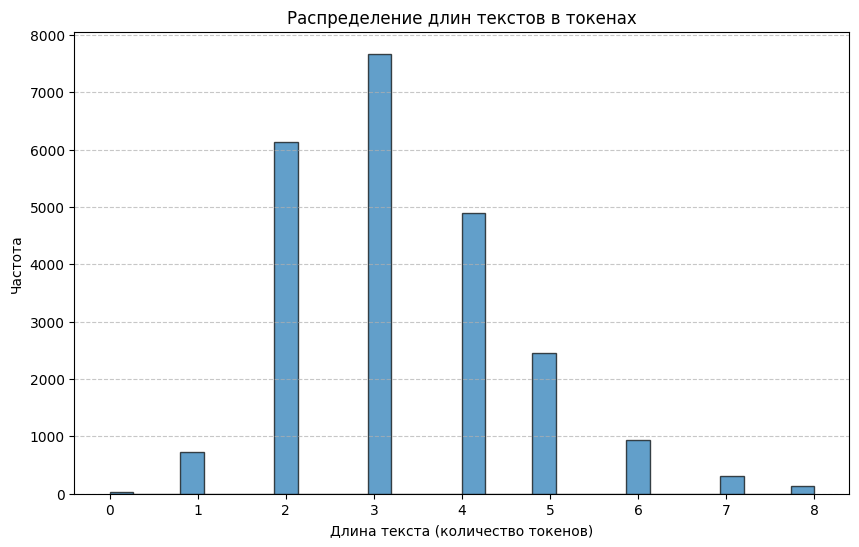

In [108]:
train_dataset.plot_token_length_distribution()

# Модель

In [109]:
num_labels = len(label2idx)

In [110]:
from transformers import AutoConfig
from ml.model import AutoModelForTokenClassificationWithCRF, TokenClassifierCRFOutput

config = AutoConfig.from_pretrained(
    BASE_MODEL_NAME,
    num_labels=num_labels,
    id2label=idx2label,
    label2id=label2idx,
    cache_dir=DATA_CACHE,
)

model = AutoModelForTokenClassificationWithCRF.from_pretrained(
    BASE_MODEL_NAME,
    cache_dir=DATA_CACHE,
    config=config,
    ignore_mismatched_sizes=True,
)

model.reset_crf_parameters()
# model.crf.init_bio_bias(label2idx, strength=0.7)
model

Some weights of AutoModelForTokenClassificationWithCRF were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['backbone.embeddings.LayerNorm.bias', 'backbone.embeddings.LayerNorm.weight', 'backbone.embeddings.position_embeddings.weight', 'backbone.embeddings.token_type_embeddings.weight', 'backbone.embeddings.word_embeddings.weight', 'backbone.encoder.layer.0.attention.output.LayerNorm.bias', 'backbone.encoder.layer.0.attention.output.LayerNorm.weight', 'backbone.encoder.layer.0.attention.output.dense.bias', 'backbone.encoder.layer.0.attention.output.dense.weight', 'backbone.encoder.layer.0.attention.self.key.bias', 'backbone.encoder.layer.0.attention.self.key.weight', 'backbone.encoder.layer.0.attention.self.query.bias', 'backbone.encoder.layer.0.attention.self.query.weight', 'backbone.encoder.layer.0.attention.self.value.bias', 'backbone.encoder.layer.0.attention.self.value.weight', 'backbone.encoder.layer.0.intermediate.dense.bias', '

AutoModelForTokenClassificationWithCRF(
  (backbone): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,)

In [111]:
print("CRF transitions nan?", torch.isnan(model.crf.transitions).any())
print("CRF transitions min/max:", model.crf.transitions.min(), model.crf.transitions.max())

CRF transitions nan? tensor(False)
CRF transitions min/max: tensor(-0.0999, grad_fn=<MinBackward1>) tensor(0.0979, grad_fn=<MaxBackward1>)


# Обучение

In [112]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=DATA_PATH_SAVE_MODELS / MODEL_CHECKPOINT_PATH,  # Папка для сохранения моделей
    num_train_epochs=6,  # Количество эпох

    eval_strategy="epoch",  # Оценка модели после каждой эпохи
    # eval_strategy="steps",
    # eval_steps=50,  # Оценка модели каждый шаг
    logging_strategy="epoch",  # Логирование каждые N шагов
    # logging_strategy="steps",
    # logging_steps=50,  # Как часто логировать
    disable_tqdm=False,  # Отключить tqdm (нужно для работы в Colab/Kaggle)
    report_to="tensorboard",  # Логируем в TensorBoard
    logging_dir=DATA_LOG,  # Папка для логов

    save_strategy="epoch",  # Сохранение модели после каждой эпохи
    # save_strategy="steps",
    # save_steps=50, # Если save_strategy="steps"
    save_total_limit=2,  # Храним все
    load_best_model_at_end=True,  # Загружать лучшую модель после обучения
    metric_for_best_model="eval_f1_macro",  # Выбираем лучшую модель по eval_f1_macro
    greater_is_better=True,  # Чем меньше eval_loss, тем лучше модель


    per_device_train_batch_size=BATCH_SIZE,  # Размер батча на одно устройство (GPU/CPU)
    per_device_eval_batch_size=BATCH_SIZE,  # Размер батча для валидации
)


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)

steps_per_epoch = len(train_dataset.df) // training_args.per_device_train_batch_size
total_steps = steps_per_epoch * training_args.num_train_epochs


In [114]:
from transformers import get_cosine_schedule_with_warmup

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.2 * total_steps),
    num_training_steps=total_steps 
)

In [115]:
# from transformers import get_cosine_with_hard_restarts_schedule_with_warmup

# scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=int(0.1 * total_steps),
#     num_training_steps=total_steps,
#     num_cycles=2,
# )


In [116]:
# from transformers import get_polynomial_decay_schedule_with_warmup

# scheduler = get_polynomial_decay_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=int(0.1 * total_steps),
#     num_training_steps=total_steps,
#     lr_end=1e-6,
#     power=2.0,
# )


In [117]:
# from transformers import get_constant_schedule_with_warmup

# scheduler = get_constant_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=int(0.1 * total_steps),
# )


In [118]:
def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
        logits = logits[0]
    return torch.argmax(logits, dim=-1)

In [119]:
from collections import Counter


def compute_class_weights(train_dataset, num_labels):
    all_labels = [l for labels in train_dataset.labels.tolist() for l in labels if l != -100]
    counts = Counter(all_labels)
    total = sum(counts.values())
    class_weights = [total / (num_labels * counts.get(i, 1)) for i in range(num_labels)]
    return torch.tensor(class_weights, dtype=torch.float32)


In [120]:
class_weights_tensor = compute_class_weights(train_dataset, num_labels)
class_weights_tensor

tensor([2.9425e-01, 2.2168e+00, 1.5836e+00, 5.4844e+02, 8.5693e+02, 6.3298e-01,
        3.4133e-01, 3.2645e+02, 2.9806e+02])

In [121]:
from collections import Counter

def show_class_counts_and_ready_weights(train_dataset, idx2label, class_weights_tensor):
    all_labels = []
    for labels in train_dataset.labels.tolist():
        for l in labels:
            if l != -100:
                all_labels.append(l)

    counts = Counter(all_labels)

    print(f"{'Класс':20s} | {'Кол-во':10s} | {'Вес'}")
    print("-"*50)
    for i in range(len(class_weights_tensor)):
        label = idx2label[i]
        count = counts.get(i, 0)
        weight = class_weights_tensor[i].item()
        print(f"{label:20s} | {count:<10d} | {weight:.6f}")


In [122]:
show_class_counts_and_ready_weights(train_dataset, idx2label, class_weights_tensor)


Класс                | Кол-во     | Вес
--------------------------------------------------
O                    | 46596      | 0.294250
B-BRAND              | 6185       | 2.216797
I-BRAND              | 8658       | 1.583609
B-PERCENT            | 25         | 548.435547
I-PERCENT            | 16         | 856.930542
B-TYPE               | 21661      | 0.632976
I-TYPE               | 40169      | 0.341330
B-VOLUME             | 42         | 326.449738
I-VOLUME             | 46         | 298.062805


In [123]:
from collections import Counter

import numpy as np
import torch
from torch.nn import CrossEntropyLoss


def weighted_crf_loss(
    emissions,
    labels,
    attention_mask,
    crf,
    class_weights_tensor,
    alpha=0.7,
):
    labels_for_crf = labels.clone().long()
    labels_for_crf[labels_for_crf == -100] = 0

    crf_loss = -crf(
        emissions,
        labels_for_crf,
        mask=attention_mask.bool(),
        reduction="token_mean"
    )

    logits_flat = emissions.view(-1, emissions.size(-1))
    labels_flat = labels.view(-1)
    ce_loss_fn = CrossEntropyLoss(
        weight=class_weights_tensor.to(emissions.device),
        ignore_index=-100
    )
    ce_loss = ce_loss_fn(logits_flat, labels_flat)
    total_loss = alpha * crf_loss + (1 - alpha) * ce_loss
    return total_loss


def weighted_loss(
    outputs: "TokenClassifierCRFOutput",
    labels,
    model,
    class_weights_tensor,
    alpha=0.7,
    num_items_in_batch=None,
):
    emissions = outputs.logits
    loss = weighted_crf_loss(
        emissions=emissions,
        labels=labels,
        attention_mask=outputs.attention_mask,
        crf=model.crf,
        class_weights_tensor=class_weights_tensor,
        alpha=alpha,
    )
    return loss


In [124]:
from functools import partial

from ml.trainer import CustomBaseTrainer
from ml.metrics import compute_metrics

trainer = CustomBaseTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    optimizers=(optimizer, scheduler),
    compute_metrics=partial(compute_metrics, idx2label=idx2label),
    processing_class=train_dataset.tokenizer,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    compute_loss_func=partial(weighted_loss, model=model, class_weights_tensor=class_weights_tensor, alpha=0.5)
)

In [125]:
trainer.train()

d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.



Epoch,Training Loss,Validation Loss,Precision,Recall,F1 Micro,F1 Macro,Accuracy
1,1.397700,0.911661,0.503432,0.596206,0.545906,0.272904,0.868818
2,0.610800,0.592837,0.719212,0.791328,0.753548,0.579559,0.934257
3,0.301400,0.493179,0.773072,0.828591,0.799869,0.576974,0.945975
4,0.180100,0.500313,0.770795,0.847561,0.807357,0.681182,0.948105
5,0.132100,0.478607,0.817606,0.874661,0.845172,0.706007,0.957845
6,0.109200,0.485429,0.829923,0.879404,0.853947,0.711834,0.959215


d:\Projects\env_ml\.venv\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator i

TrainOutput(global_step=1098, training_loss=0.4552126173981769, metrics={'train_runtime': 377.0291, 'train_samples_per_second': 370.762, 'train_steps_per_second': 2.912, 'total_flos': 20152520245440.0, 'train_loss': 0.4552126173981769, 'epoch': 6.0})

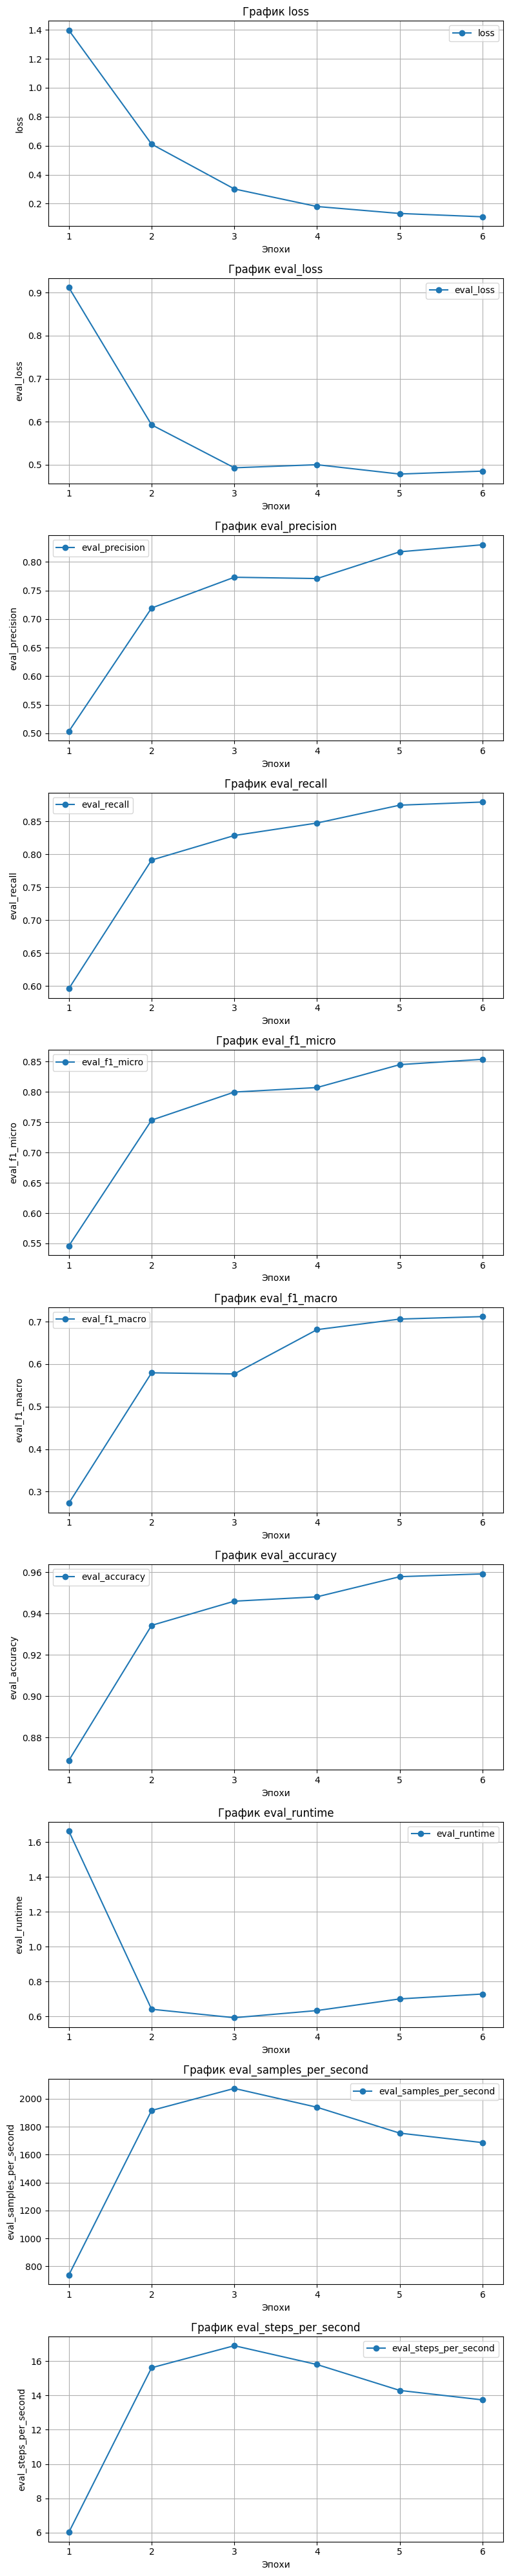

In [126]:
trainer.plot_results()

In [127]:
test_results = trainer.predict(test_dataset)
print(test_results.metrics)

d:\Projects\env_ml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.



{'test_loss': 0.3672468662261963, 'test_precision': 0.8460859329017069, 'test_recall': 0.8837995696280356, 'test_f1_micro': 0.8645316493760336, 'test_f1_macro': 0.6621069031055056, 'test_accuracy': 0.958879536359873, 'test_runtime': 1.5909, 'test_samples_per_second': 1713.469, 'test_steps_per_second': 13.828}


In [129]:
trainer.save_model(DATA_PATH_SAVE_MODELS / MODEL_NAME_SAVE)

# Тестирование модели

In [130]:
from regex import D
from transformers import AutoConfig
from ml.model import AutoModelForTokenClassificationWithCRF, TokenClassifierCRFOutput

num_labels = len(label2idx)

config = AutoConfig.from_pretrained(
    DATA_PATH_SAVE_MODELS / "ner_x5",
    num_labels=num_labels,
    id2label=idx2label,
    label2id=label2idx,
    cache_dir=DATA_CACHE,
)

model = AutoModelForTokenClassificationWithCRF.from_pretrained(
    DATA_PATH_SAVE_MODELS / "ner_x5",
    cache_dir=DATA_CACHE,
    config=config,
    ignore_mismatched_sizes=True,
)

In [131]:
test_dataset.analyze_with_model(
    model=model, 
    idx2label=idx2label, 
    batch_size=64, 
    device="cuda" if torch.cuda.is_available() else "cpu", 
    layer=-1
)

Analyzing with model: 100%|█████████████████████████████████████████| 43/43 [00:02<00:00, 15.49it/s]


In [132]:
# test_dataset.df.sample(10)

In [133]:
print(test_dataset.df["is_correct"].value_counts())

is_correct
True     2456
False     270
Name: count, dtype: int64


In [134]:
df_true = test_dataset.df[test_dataset.df["is_correct"] == True]
df_true.sample(5)

,sample,annotation,df_label,tokens_ids_debug,tokens_text_debug,labels_debug,pred_labels,entities,is_correct
1458,капюртофель,"[(0, 11, B-TYPE)]",x5,"[2, 33008, 36471, 1026, 53019, 3, 0, 0, 0, 0]","[[CLS], кап, ##юр, ##то, ##фель, [SEP], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O, O]","[{'start_index': 0, 'end_index': 11, 'entity': 'B-TYPE', 'word': 'капюртофель'}]",True
710,сосиську,"[(0, 8, B-TYPE)]",x5,"[2, 71131, 20953, 3, 0, 0, 0, 0, 0, 0]","[[CLS], сосис, ##ьку, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, O, O, O, O, O, O, O]","[O, B-TYPE, I-TYPE, O, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 8, 'entity': 'B-TYPE', 'word': 'сосиську'}]",True
2063,темьо для чебурек,"[(0, 5, B-TYPE), (6, 9, I-TYPE), (10, 17, I-TYPE)]",x5,"[2, 5624, 19011, 871, 3342, 19110, 3807, 3, 0, 0]","[[CLS], тем, ##ьо, для, че, ##бур, ##ек, [SEP], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O]","[{'start_index': 0, 'end_index': 5, 'entity': 'B-TYPE', 'word': 'темьо'}, {'start_index': 6, 'end_index': 9, 'entity': 'I-TYPE', 'word': 'для'}, {'start_index': 10, 'end_index': 17, 'entity': 'I-TYPE', 'word': 'чебурек'}]",True
741,печенеье,"[(0, 8, B-TYPE)]",x5,"[2, 35933, 987, 5976, 3, 0, 0, 0, 0, 0]","[[CLS], пече, ##не, ##ье, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 8, 'entity': 'B-TYPE', 'word': 'печенеье'}]",True
865,слоное,"[(0, 6, B-TYPE)]",x5,"[2, 72144, 4427, 3, 0, 0, 0, 0, 0, 0]","[[CLS], слон, ##ое, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, O, O, O, O, O, O, O]","[O, B-TYPE, I-TYPE, O, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 6, 'entity': 'B-TYPE', 'word': 'слоное'}]",True


In [135]:
df_false = test_dataset.df[test_dataset.df["is_correct"] == False]
df_false.sample(10)

,sample,annotation,df_label,tokens_ids_debug,tokens_text_debug,labels_debug,pred_labels,entities,is_correct
2102,экзо,"[(0, 4, B-BRAND)]",x5,"[2, 4486, 721, 3, 0, 0, 0, 0, 0, 0]","[[CLS], экз, ##о, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-BRAND, I-BRAND, O, O, O, O, O, O, O]","[O, B-TYPE, I-TYPE, O, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 4, 'entity': 'B-TYPE', 'word': 'экзо'}]",False
2611,груша вильямс,"[(0, 5, B-TYPE), (6, 13, I-TYPE)]",x5,"[2, 82371, 603, 25040, 24819, 15480, 3, 0, 0, 0]","[[CLS], груш, ##а, ви, ##лья, ##мс, [SEP], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O, O]","[O, B-TYPE, I-TYPE, B-BRAND, I-TYPE, I-TYPE, O, O, O, O]","[{'start_index': 0, 'end_index': 5, 'entity': 'B-TYPE', 'word': 'груша'}, {'start_index': 6, 'end_index': 13, 'entity': 'B-BRAND', 'word': 'вильямс'}]",False
1548,селяночка,"[(0, 9, B-BRAND)]",x5,"[2, 28496, 27320, 3, 0, 0, 0, 0, 0, 0]","[[CLS], селян, ##очка, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-BRAND, I-BRAND, O, O, O, O, O, O, O]","[O, B-TYPE, I-BRAND, O, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 9, 'entity': 'B-TYPE', 'word': 'селяночка'}]",False
335,дэмка паштет,"[(0, 5, B-BRAND), (6, 12, B-TYPE)]",x5,"[2, 316, 12447, 872, 2189, 10850, 751, 3, 0, 0]","[[CLS], д, ##эм, ##ка, па, ##ште, ##т, [SEP], [PAD], [PAD]]","[O, B-BRAND, I-BRAND, I-BRAND, B-TYPE, I-TYPE, I-TYPE, O, O, O]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, I-TYPE, O, O, O]","[{'start_index': 0, 'end_index': 5, 'entity': 'B-TYPE', 'word': 'дэмка'}, {'start_index': 6, 'end_index': 12, 'entity': 'I-TYPE', 'word': 'паштет'}]",False
1618,кофе mild fresco,"[(0, 4, B-TYPE), (5, 9, B-BRAND), (10, 16, I-BRAND)]",x5,"[2, 32912, 25181, 1911, 13941, 559, 3, 0, 0, 0]","[[CLS], кофе, mild, fr, ##esc, ##o, [SEP], [PAD], [PAD], [PAD]]","[O, B-TYPE, B-BRAND, I-BRAND, I-BRAND, I-BRAND, O, O, O, O]","[O, B-TYPE, B-BRAND, B-BRAND, I-BRAND, I-BRAND, O, O, O, O]","[{'start_index': 0, 'end_index': 4, 'entity': 'B-TYPE', 'word': 'кофе'}, {'start_index': 5, 'end_index': 9, 'entity': 'B-BRAND', 'word': 'mild'}, {'start_index': 10, 'end_index': 16, 'entity': 'B-BRAND', 'word': 'fresco'}]",False
1640,кому-нибудь letto,"[(0, 11, B-TYPE), (12, 17, B-BRAND)]",x5,"[2, 30411, 17, 30027, 3353, 559, 3, 0, 0, 0]","[[CLS], кому, -, нибудь, lett, ##o, [SEP], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, B-BRAND, I-BRAND, O, O, O, O]","[O, B-TYPE, I-TYPE, I-TYPE, I-TYPE, I-BRAND, O, O, O, O]","[{'start_index': 0, 'end_index': 11, 'entity': 'B-TYPE', 'word': 'кому-нибудь'}, {'start_index': 12, 'end_index': 17, 'entity': 'I-TYPE', 'word': 'letto'}]",False
63,фейр,"[(0, 4, B-BRAND)]",x5,"[2, 36276, 870, 3, 0, 0, 0, 0, 0, 0]","[[CLS], фей, ##р, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-BRAND, I-BRAND, O, O, O, O, O, O, O]","[O, B-TYPE, I-TYPE, O, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 4, 'entity': 'B-TYPE', 'word': 'фейр'}]",False
2712,нож мистери,"[(0, 3, B-TYPE), (4, 11, B-BRAND)]",x5,"[2, 42547, 45012, 613, 3, 0, 0, 0, 0, 0]","[[CLS], нож, мистер, ##и, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, B-BRAND, I-BRAND, O, O, O, O, O, O]","[O, B-TYPE, I-TYPE, I-TYPE, O, O, O, O, O, O]","[{'start_index': 0, 'end_index': 3, 'entity': 'B-TYPE', 'word': 'нож'}, {'start_index': 4, 'end_index': 11, 'entity': 'I-TYPE', 'word': 'мистери'}]",False
520,шпикачки окраи,"[(0, 9, B-TYPE), (10, 15, B-BRAND)]",x5,"[2, 2690, 3544, 3432, 36106, 3, 0, 0, 0, 0]","[[CLS], шп, ##ика, ##чки, окраи, [SEP], [PAD], [PAD], [PAD], [PAD]]","[O, B-TYPE, I-TYPE, I-TYPE, B-BRAND, O, O, O, O, O]","[O, B-TYPE, I-TYPE, I-TYPE, B-BRAND, O, O, O, O, O]","[{'start_index': 0, 'end_index': 8, 'entity': 'B-TYPE', 'word': 'шпикачки'}, {'start_index': 10, 'end_index': 15, 'entity': 'B-BRAND', 'word': 'окраи'}]",False
1559,сухой корм для кошек пурина,"[(0, 5, B-TYPE), (6, 10, I-TYPE), (11, 14, I-TYPE), (15, 20, I-TYPE), (21, 27, B-BRAND)]",x5,"[2, 39436, 38962, 871, 38396, 65

# Визуализация по типам

In [136]:
def aggregate_entities(dataset):
    entity_embs = []
    entity_labels = []
    entity_texts = []

    for i, row in dataset.df.iterrows():
        words = dataset._embeddings[i]["words"]
        entropies = dataset._entropies[i]["words"]
        entities = row["entities"]

        for ent in entities:
            if ent["entity"] == "O":
                continue

            start, end = ent["start_index"], ent["end_index"]
            ent_label = ent["entity"].split("-", 1)[-1]
            ent_text = ent.get("word", row["sample"][start:end])

            word_vecs = [w["emb"] for w in words if w["start"] >= start and w["end"] <= end]
            if not word_vecs:
                continue

            ent_vec = torch.stack(word_vecs).mean(dim=0).numpy()
            entity_embs.append(ent_vec)
            entity_labels.append(ent_label)
            entity_texts.append(ent_text)

    entity_df = pd.DataFrame({
        "entity_text": entity_texts,
        "entity_label": entity_labels
    })
    return np.stack(entity_embs), entity_df


In [137]:
from sklearn.preprocessing import LabelEncoder

from ml.visualizer import DynamicEmbeddingVisualizer

entity_embs, entity_df = aggregate_entities(test_dataset)

le = LabelEncoder()
labels = le.fit_transform(entity_df["entity_label"].tolist())

vis = DynamicEmbeddingVisualizer(entity_embs, entity_df, labels=labels)

vis.reduce_dimensionality(method="tsne", n_components=2)

vis.visualize(
    method="tsne",
    title="Entity-level Embeddings",
    hover_columns=["entity_text", "entity_label"],
    idx2label={i: lbl for i, lbl in enumerate(le.classes_)}
)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4257 samples in 0.001s...
[t-SNE] Computed neighbors for 4257 samples in 0.208s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4257
[t-SNE] Computed conditional probabilities for sample 2000 / 4257
[t-SNE] Computed conditional probabilities for sample 3000 / 4257
[t-SNE] Computed conditional probabilities for sample 4000 / 4257
[t-SNE] Computed conditional probabilities for sample 4257 / 4257
[t-SNE] Mean sigma: 1.584002
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.479057
[t-SNE] KL divergence after 1000 iterations: 1.225722


# Энтропии

In [138]:
thresholds = test_dataset.compute_entropy_thresholds(
    idx2label=idx2label,
    method="prc"
)



d:\Projects\env_ml\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

d:\Projects\env_ml\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

d:\Projects\env_ml\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

d:\Projects\env_ml\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

d:\Projects\env_ml\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

d:\Projects\env_ml\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1046: UserWarning:

No positive class found in y_true, recall is set to one for all thres

In [139]:
print("Entropy thresholds per class:")
for k, v in thresholds.items():
    print(f"{k}: {v:.4f}")

Entropy thresholds per class:
B-BRAND: 0.0310
I-BRAND: 0.0338
B-PERCENT: 0.4081
B-TYPE: 0.0115
I-TYPE: 0.0185
B-VOLUME: 0.2077
I-VOLUME: 0.3945


In [140]:
avg_threshold = np.mean(list(thresholds.values()))

results_confident = test_dataset.evaluate_accuracy_by_entropy_thresholds(
    thresholds=thresholds,
    avg_threshold=avg_threshold,
    confident=True,
    idx2label=idx2label
)
print("\n=== Уверенные предсказания ===")
print(f"Точность: {results_confident['accuracy']:.2%}")


Samples selected: 3117
Accuracy (confident): 98.17%
Coverage: 114.34%

=== Уверенные предсказания ===
Точность: 98.17%


In [166]:
results_confident["predictions_df"].sample(10)

,text,entity_text,true_entities,pred_entity,entropy,threshold,correct
113,йикорий,йикорий,"[(0, 7, B-TYPE)]",B-TYPE,0.039521,0.157873,1
2824,кофейник vites,кофейник,"[(9, 14, B-BRAND), (0, 8, B-TYPE)]",B-TYPE,0.031297,0.157873,1
1685,йогурт детский,йогурт,"[(7, 14, I-TYPE), (0, 6, B-TYPE)]",B-TYPE,0.019398,0.157873,1
1482,копчёности,копчёности,"[(0, 10, B-TYPE)]",B-TYPE,0.030618,0.157873,1
2556,рис красно,рис,"[(4, 10, I-TYPE), (0, 3, B-TYPE)]",B-TYPE,0.024860,0.157873,1
1886,окорок слово мясника,слово,"[(7, 12, I-TYPE), (13, 20, I-TYPE), (0, 6, B-TYPE)]",B-BRAND,0.107561,0.157873,0
2090,lind,lind,"[(0, 4, B-BRAND)]",B-BRAND,0.106300,0.157873,1
209,колбаса окраина брауншвейгская,окраина,"[(16, 30, I-BRAND), (0, 7, B-TYPE), (8, 15, B-BRAND)]",B-BRAND,0.074999,0.157873,1
2198,булоча,булоча,"[(0, 6, B-TYPE)]",B-TYPE,0.020616,0.157873,1
2296,artfruit нектари,нектари,"[(9, 16, B-TYPE), (0, 8, B-BRAND)]",B-TYPE,0.118901,0.157873,1


In [142]:
results_uncertain = test_dataset.evaluate_accuracy_by_entropy_thresholds(
    thresholds=thresholds,
    avg_threshold=avg_threshold,
    confident=False,
    idx2label=idx2label
)

print("\n=== Неуверенные предсказания ===")
print(f"Точность: {results_uncertain['accuracy']:.2%}")

Samples selected: 1140
Accuracy (uncertain): 78.77%
Coverage: 41.82%

=== Неуверенные предсказания ===
Точность: 78.77%


In [143]:
results_uncertain["predictions_df"].sample(10)

,text,entity_text,true_entities,pred_entity,entropy,threshold,correct
766,маслом,маслом,"[(0, 6, B-TYPE)]",B-TYPE,0.203328,0.157873,1
230,пахлава petr,пахлава,"[(0, 7, B-TYPE), (8, 12, B-BRAND)]",B-TYPE,0.341908,0.157873,1
883,бомбар,бомбар,"[(0, 6, B-BRAND)]",B-TYPE,0.289808,0.157873,0
543,aquaftesh,aquaftesh,"[(0, 9, B-BRAND)]",B-BRAND,0.418888,0.157873,1
1068,сыр красная,красная,"[(4, 11, I-TYPE), (0, 3, B-TYPE)]",I-TYPE,0.455666,0.157873,1
852,эинкали,эинкали,"[(0, 7, B-TYPE)]",B-TYPE,0.223967,0.157873,1
913,хагис,хагис,"[(0, 5, B-BRAND)]",B-TYPE,0.536469,0.157873,0
162,snak,snak,"[(0, 4, B-TYPE)]",B-TYPE,0.662781,0.157873,1
4,печенье с цукатами,с,"[(10, 18, I-TYPE), (0, 7, B-TYPE), (8, 9, I-TYPE)]",I-TYPE,0.480432,0.157873,1
437,хлеб.,хлеб.,"[(0, 5, B-TYPE)]",B-TYPE,0.167756,0.157873,1


# Ручное тестирование

In [144]:
import json
from pathlib import Path

from ml.pipline import NERPipelineCRF

model_dir = DATA_PATH_SAVE_MODELS / "ner_x5"
label2idx_path = DATA_PATH_SAVE_MODELS / "label2idx.json"
idx2label_path = DATA_PATH_SAVE_MODELS / "idx2label.json"

with open(label2idx_path, "r", encoding="utf-8") as f:
    label2idx = json.load(f)

with open(idx2label_path, "r", encoding="utf-8") as f:
    idx2label = {int(k): v for k, v in json.load(f).items()}

pipeline = NERPipelineCRF(
    model_path=model_dir,
    label2idx=label2idx,
    idx2label=idx2label,
    max_length=16
)


In [145]:
text = [
    "йогурт данисимо фантазия",
    "молоко простоквашино 3.2% 930г",
    "хлеб бородинский нарезка 300г",
    "мороженнае как бы его взтять",
    "молоко⁷ цельное",
    "паштет для кошки",
    "погремушки fisher-pri",   
    "сырокопченая-колбаск",
    "мясное пюре для пупсов, 250г,",
]
entities = pipeline.predict(text, return_word=True)

for i, entity in enumerate(entities):
    print(f"Текст: {text[i]}")
    print(entity)

Текст: йогурт данисимо фантазия
[{'start_index': 0, 'end_index': 6, 'entity': 'B-TYPE', 'word': 'йогурт'}, {'start_index': 7, 'end_index': 15, 'entity': 'B-BRAND', 'word': 'данисимо'}, {'start_index': 16, 'end_index': 24, 'entity': 'I-BRAND', 'word': 'фантазия'}]
Текст: молоко простоквашино 3.2% 930г
[{'start_index': 0, 'end_index': 6, 'entity': 'B-TYPE', 'word': 'молоко'}, {'start_index': 7, 'end_index': 20, 'entity': 'B-BRAND', 'word': 'простоквашино'}, {'start_index': 21, 'end_index': 25, 'entity': 'B-PERCENT', 'word': '3.2%'}, {'start_index': 26, 'end_index': 30, 'entity': 'B-BRAND', 'word': '930г'}]
Текст: хлеб бородинский нарезка 300г
[{'start_index': 0, 'end_index': 4, 'entity': 'B-TYPE', 'word': 'хлеб'}, {'start_index': 5, 'end_index': 16, 'entity': 'I-TYPE', 'word': 'бородинский'}, {'start_index': 17, 'end_index': 24, 'entity': 'I-TYPE', 'word': 'нарезка'}, {'start_index': 25, 'end_index': 29, 'entity': 'I-BRAND', 'word': '300г'}]
Текст: мороженнае как бы его взтять
[{'start_i

In [146]:
import pandas as pd
from tqdm import tqdm

def run_inference_on_dataframe(
    pipeline, 
    df: pd.DataFrame,
    text_col: str = "sample", 
    batch_size: int = 64
) -> pd.DataFrame:
    
    texts = df[text_col].tolist()
    all_entities = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Running inference", ncols=100):
        batch_texts = texts[i:i+batch_size]
        batch_entities = pipeline.predict(batch_texts, batch_size=batch_size)
        all_entities.extend(batch_entities)

    formatted_entities = [
        [(ent["start_index"], ent["end_index"], ent["entity"]) for ent in ents]
        for ents in all_entities
    ]

    df_result = pd.DataFrame({
        "id": range(1, len(texts) + 1),
        "search_query": texts,
        "annotation": formatted_entities
    })

    return df_result


In [147]:
df_result = run_inference_on_dataframe(pipeline, df_submission, text_col="sample", batch_size=64)


Running inference: 100%|████████████████████████████████████████████| 79/79 [00:03<00:00, 23.31it/s]


In [148]:
df_result.sample(5)

,id,search_query,annotation
1431,1432,mol,"[(0, 3, B-TYPE)]"
2309,2310,осетровые,"[(0, 9, B-TYPE)]"
3952,3953,олейна,"[(0, 6, B-TYPE)]"
360,361,яблоко вишня,"[(0, 6, B-TYPE), (7, 12, I-TYPE)]"
3781,3782,погремушки плейгр,"[(0, 10, B-TYPE), (11, 17, B-BRAND)]"


In [151]:
df_result.to_csv(DATA_PATH_DOWNLOAD /  "submission.csv", index=False, sep=";")
